In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from pandas import DataFrame, concat
from pprint import pprint

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(parent_dir)

assert os.path.exists('data') == True, (
    'diretório data não encontrado. '
    'Certifique-se de que o diretório data existe no diretório raiz desse '
    'projeto, com os arquivos necessários dentro.'
)

os.makedirs('results', exist_ok=True)



# Constantes

Os valores abaixo serão utilizados para retornar os valores de previsão para a escala original. 

Além de desnormalizar é necessário readicionar a tendência que foi retirada a partir da diferenciação da série do ICMS-RJ.

In [2]:
# Constantes para a validação
# 25 valores para criar 13 intervalos de 12 meses
icms_initial_values = [3054647241.0, 2899400405.0, 2718750710.0, 
                       2784291530.0, 2988242758.0, 2728014302.0, 
                       3400196101.0, 3228952138.0, 2873691468.0, 
                       2694165362.0, 4479663014.0, 2867019408.0, 
                       3586300282.0, 3192884893.0, 2763545556.0, 
                       3193576905.0, 2983787440.0, 2737799049.08, 
                       2753485166.27, 2931044987.21, 3114528093.4, 
                       3124850205.99, 3143348373.33, 3490147653.84,
                       3859316053.66]

cb_initial_values = [443.81, 438.36, 441.19, 440.06, 446.03, 445.58, 
                     421.89, 417.05, 418.48, 443.69, 460.24, 466.75, 
                     460.46, 464.47, 496.33, 515.58, 492.93, 498.67, 
                     479.28, 462.24, 458.21, 462.57, 455.37, 516.91,
                     644.0]

petr_initial_values = [2724, 2729, 2672, 2714, 2718, 2707, 2690, 2614, 
                       2578, 2717, 2671, 2794, 2730, 2582, 2655, 2700, 
                       2834, 2654, 2877, 3097, 3038, 3075, 3203, 3216,
                       2969]

trib_initial_values = [4869304104.0, 3911455913.0, 3553175853.0, 
                       3557404009.0, 3632787716.0, 3305049163.0, 
                       4047070676.0, 3901651824.0, 3444939721.0, 
                       3272112477.0, 5096900924.0, 3456062224.0, 
                       5464521206.0, 4185558828.0, 3621893885.0, 
                       3959255086.0, 3592748799.0, 3300752325.67, 
                       3321406806.42, 3508106369.08, 3641413728.43, 
                       3665239552.24, 3657823494.71, 4063564350.02,
                       5496860058.37]

ener_initial_values = [20078.0, 19690.0, 20853.0, 20733.0, 19736.0, 19179.0, 
                       19273.0, 19378.0, 19600.0, 20110.0, 20154.0, 20022.0, 
                       20966.0, 20585.0, 20626.0, 19828.0, 20187.0, 18981.0, 
                       18700.0, 18900.0, 19292.0, 20171.0, 20623.0, 19593.0,
                       21498.0]

# Constantes para os testes
icms_test_real = [4327920118.33, 3621238631.11, 3349671547.87, 
                  4123153077.77, 3750000648.34, 4142199873.63, 
                  3574957480.03, 3409293931.52, 4297149120.6, 
                  3404457118.32, 3622801505.3, 3334894194.52]

initial_icms_test_value = 4021877984.35


#### Importando e Plotando as séries
No CSV estão salvas apenas as séries selecionadas após a aplicação do DTW e diferenciadas para remover a tendência. Por esse motivo todas as séries são estacionárias.

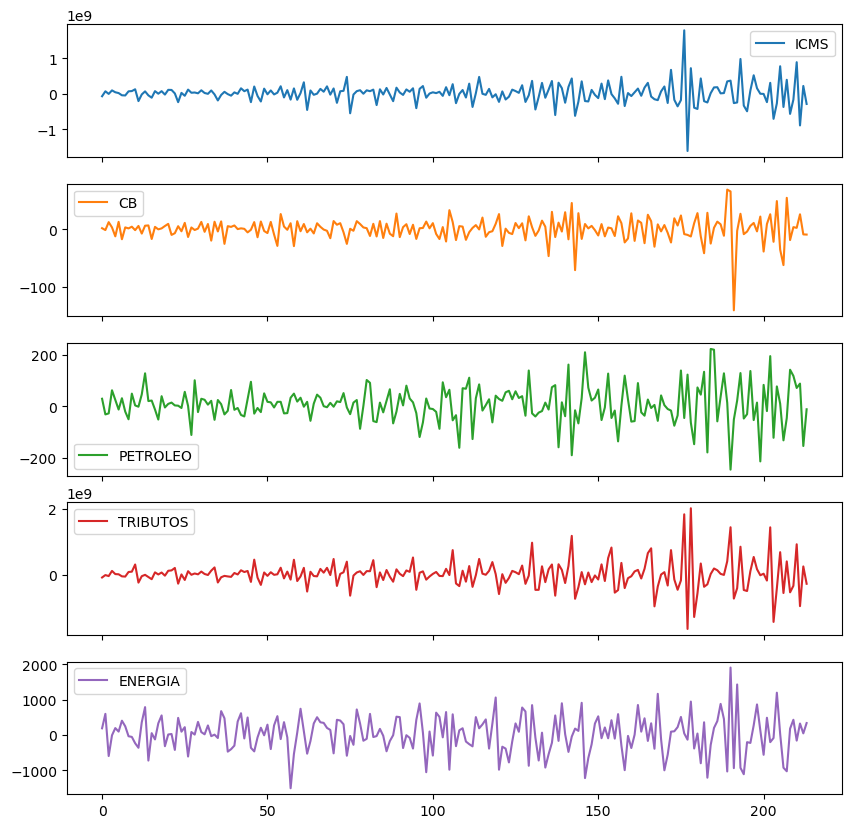

In [3]:
df = pd.read_csv('data/selected.csv', header=0, names=['ANO', 'MES', 'ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA'])
plot = df[df.columns[2:]].plot(figsize=(10, 10), subplots=True)

## Separando o conjunto de Teste

In [4]:
df_test = df[df['ANO'] == 2022].copy()
df = df[df['ANO'] != 2022].copy()
print(df.shape, df_test.shape)

(202, 7) (12, 7)


## Normalizando as séries
Os valores Máximo e Mínimo do ICMS são salvos para que seja possível retornar com as previsões para as escala original.

In [5]:
#Normalizing data   
_min = df['ICMS'].min()
_max = df['ICMS'].max()

cb_min = df['CB'].min()
cb_max = df['CB'].max()

petr_min = df['PETROLEO'].min()
petr_max = df['PETROLEO'].max()

trib_min = df['TRIBUTOS'].min()
trib_max = df['TRIBUTOS'].max()

ener_min = df['ENERGIA'].min()
ener_max = df['ENERGIA'].max()

for col in df.columns[2:]:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [6]:
df.head()

,ANO,MES,ICMS,CB,PETROLEO,TRIBUTOS,ENERGIA
0,2004.0,3.0,0.453713,0.680444,0.587234,0.426264,0.496627
1,2004.0,4.0,0.494609,0.664873,0.457447,0.446347,0.616310
2,2004.0,5.0,0.473085,0.730537,0.465957,0.437884,0.266940
3,2004.0,6.0,0.502279,0.686920,0.657447,0.480698,0.438838
4,2004.0,7.0,0.486677,0.612923,0.578723,0.454444,0.498387


# Definição de funções

In [6]:
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{columns[j]}(t-{i})') for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{columns[j]}(t)') for j in range(n_vars)]
        else:
            names += [(f'{columns[j]}(t+{i})') for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_best_parameters(best_dict):
    """
    Function to get the best parameters from the dictionary
    Parameters:
    best_dict: Dictionary returned by the grid search
    return: Tuple with the best parameters
        ne: n_estimators
        md: max_depth
        lr: leraning_rate   
        ss: subsample
        cb: colsample_bytree
        b: booster
    """
    ne = best_dict['n_estimators']
    md = best_dict['max_depth']
    lr = best_dict['learning_rate']
    ss = best_dict['subsample']
    cb = best_dict['colsample_bytree']
    b = best_dict['booster']
    return ne, md, lr, ss, cb, b

def print_mean_error(name, rmse, mae, mape):
    """
    Function to print the mean error
    Parameters:
    name: Name of the case
    rmse: numpy array with the rmse values
    mae: numpy array with the mae values
    mape: numpy array with the mape values
    return: None
    """
    mean_rmse = np.mean(rmse)
    mean_mae = np.mean(mae)
    mean_mape = np.mean(mape)
    print(f'{name}')
    print(f'\tRMSE: {mean_rmse:.2f}')
    print(f'\tMAE: {mean_mae:.2f}')
    print(f'\tMAPE: {mean_mape:.2f}')
    print('-'*40)

def denorm_and_retrend(y_pred, y_val_case, icms_max, icms_min, 
                       s_max, s_min, icms_initial, s_initial):
    """
    Function to remove the normalization and retrend the data
    Parameters:
    y_pred: numpy array with the predicted values
    y_val_case: numpy array with the real values of the case (validation)
    icms_max: maximum value of the icms
    icms_min: minimum value of the icms
    s_max: maximum value of the serie of the case
    s_min: minimum value of the serie of the case
    icms_initial: initial value of the icms for retrend icms
    s_initial: initial value of the serie for retrend icms
    return: 
    y_pred: numpy array with the predicted values denormalized and retrended
    y_val_case: numpy array with the real values of the case (validation) denormalized and retrended
    """                       
    y_pred = np.array(y_pred).reshape(12, 2)
    norm1, norm2 = np.split(y_pred, 2, axis=1)
    norm1 = norm1 * (icms_max - icms_min) + icms_min
    norm2 = norm2 * (s_max - s_min) + s_min

    y_val_case = np.array(y_val_case).reshape(12, 2)
    val_norm1, val_norm2 = np.split(y_val_case, 2, axis=1)
    val_norm1 = val_norm1 * (icms_max - icms_min) + icms_min
    val_norm2 = val_norm2 * (s_max - s_min) + s_min 

    for j in range(12):
        if j == 0:
            norm1[j] = norm1[j] + icms_initial
            val_norm1[j] = val_norm1[j] + icms_initial
            norm2[j] = norm2[j] + s_initial
            val_norm2[j] = val_norm2[j] + s_initial
        else:
            norm1[j] = norm1[j] + norm1[j-1]
            val_norm1[j] = val_norm1[j] + val_norm1[j-1]
            norm2[j] = norm2[j] + norm2[j-1]
            val_norm2[j] = val_norm2[j] + val_norm2[j-1]

    y_pred = np.concatenate((norm1, norm2), axis=1).reshape(-1, 1)
    y_val_case = np.concatenate((val_norm1, val_norm2), axis=1).reshape(-1, 1)

    return y_pred, y_val_case

def calculate_error(y_pred, y_val):
    """
    Function to calculate the errors RMSE, MAE and MAPE
    Parameters:
    y_pred: numpy array with the predicted values (without normalization and retrended)
    y_val: numpy array with the real values (without normalization and retrended)
    return:
    rmse: RMSE value
    mae: MAE value
    mape: MAPE value
    """
    rmse = np.sqrt(mean_squared_error(y_pred, y_val))
    mae = np.mean(np.abs(y_val - y_pred))
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

    return rmse, mae, mape

def denorm_and_retrend_all(y_pred, y_val, initial, cb_initial, petr_initial, 
                           trib_initial, ener_initial):
    """
    Function to remove the normalization and retrend the data of the case
    that all series are used
    Parameters:
    y_pred: numpy array with the predicted values
    y_val: numpy array with the real values of the case (validation)
    initial: initial value of the serie for retrend icms
    cb_initial: initial value of the serie for retrend cb
    petr_initial: initial value of the serie for retrend petr
    trib_initial: initial value of the serie for retrend trib   
    ener_initial: initial value of the serie for retrend ener
    """
    y_pred = np.array(y_pred).reshape(12, 5)
    norm1, norm2, norm3, norm4, norm5 = np.split(y_pred, 5, axis=1)
    norm1 = norm1 * (_max - _min) + _min
    norm2 = norm2 * (cb_max - cb_min) + cb_min
    norm3 = norm3 * (petr_max - petr_min) + petr_min
    norm4 = norm4 * (trib_max - trib_min) + trib_min
    norm5 = norm5 * (ener_max - ener_min) + ener_min

    y_val = np.array(y_val).reshape(12, 5)
    norm1_val, norm2_val, norm3_val, norm4_val, norm5_val = np.split(y_val, 5, axis=1)
    norm1_val = norm1_val * (_max - _min) + _min
    norm2_val = norm2_val * (cb_max - cb_min) + cb_min
    norm3_val = norm3_val * (petr_max - petr_min) + petr_min
    norm4_val = norm4_val * (trib_max - trib_min) + trib_min
    norm5_val = norm5_val * (ener_max - ener_min) + ener_min

    for j in range(12):
        if j == 0:
            norm1[j] = norm1[j] + initial
            norm2[j] = norm2[j] + cb_initial
            norm3[j] = norm3[j] + petr_initial
            norm4[j] = norm4[j] + trib_initial
            norm5[j] = norm5[j] + ener_initial
            norm1_val[j] = norm1_val[j] + initial
            norm2_val[j] = norm2_val[j] + cb_initial
            norm3_val[j] = norm3_val[j] + petr_initial
            norm4_val[j] = norm4_val[j] + trib_initial
            norm5_val[j] = norm5_val[j] + ener_initial
        else:
            norm1[j] = norm1[j] + norm1[j-1]
            norm2[j] = norm2[j] + norm2[j-1]
            norm3[j] = norm3[j] + norm3[j-1]
            norm4[j] = norm4[j] + norm4[j-1]
            norm5[j] = norm5[j] + norm5[j-1]
            norm1_val[j] = norm1_val[j] + norm1_val[j-1]
            norm2_val[j] = norm2_val[j] + norm2_val[j-1]
            norm3_val[j] = norm3_val[j] + norm3_val[j-1]
            norm4_val[j] = norm4_val[j] + norm4_val[j-1]
            norm5_val[j] = norm5_val[j] + norm5_val[j-1]

    y_pred = np.concatenate((norm1, norm2, norm3, norm4, norm5), axis=1)
    y_pred = y_pred.reshape(-1, 1)
    y_val = np.concatenate((norm1_val, norm2_val, norm3_val, norm4_val, norm5_val), axis=1)
    y_val = y_val.reshape(-1, 1)

    return y_pred, y_val

def get_prediction(test_values, model, initial):
    """
    Function used in test set to predict the next 12 months in a multistep
    forecast. The prediction is made using the model passed as parameter.
    Parameters:
    test_values: numpy array with the values of the last line of the validation set
    model: model used to predict the next 12 months
    initial: initial value of the serie for retrend
    return:
    pred: numpy array with the predicted values denormalized and retrended
    """
    pred = []

    for i in range(12):
        y_hat = model.predict(test_values.reshape(1, -1))
        test_values = np.concatenate([test_values[2:], y_hat.reshape(-1)], axis=0)
        #Desnormalizing
        y_hat = y_hat * (_max - _min) + _min
        pred.append(y_hat[0][0])

    #Retrending
    for i in range(12):
        if i == 0:
            pred[i] = pred[i] + initial
        else:
            pred[i] = pred[i] + pred[i-1]

    pred = np.array(pred)
    return pred

def print_results(name, pred, real):
    """
    Print the results of the model on the test set
    Parameters:
    name: name of the case
    pred: numpy array with the predicted values
    real: numpy array with the real values
    return: None
    """
    rmse, mae, mape = calculate_error(pred, real)
    print(f'{name}')
    print(f'\tRMSE: {rmse:.2f}')
    print(f'\tMAE: {mae:.2f}')
    print(f'\tMAPE: {mape:.2f}')
    print('-'*40)
 

# Univariado
Primeiro vamos usar apenas o ICMS para realizar a previsão multi-step.

In [8]:
icms = series_to_supervised(list(df['ICMS']), ['ICMS'], 12, 1)
icms.shape


(190, 13)

#### GridSearch com CV para XGBRegressor and XGBRFRegressor

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 210, num = 21)]
max_depth.append(None)
# Learning rate
learning_rate = [round(x,3) for x in np.linspace(0.001, 0.1, num = 10)]
# Subsample parameter
subsample = [0.8, 0.9, 1.0]
# Colsample bytree parameter
colsample_bytree = [0.8, 0.9, 1.0]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'booster': ['gbtree', 'gblinear', 'dart']}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgbr = xgb.XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgbr_random = RandomizedSearchCV(estimator = xgbr, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, scoring='neg_mean_squared_error',
                               verbose=2, n_jobs = -1)
# Fit the random search model
xgbr_random.fit(icms.values[:, :-1], icms.values[:, -1])

xgbr_ne = xgbr_random.best_params_['n_estimators']
xgbr_md = xgbr_random.best_params_['max_depth']
xgbr_lr = xgbr_random.best_params_['learning_rate']
xgbr_ss = xgbr_random.best_params_['subsample']
xgbr_cb = xgbr_random.best_params_['colsample_bytree']
xgbr_b = xgbr_random.best_params_['booster']
pprint(xgbr_random.best_params_)

xgbrfr = xgb.XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgbrfr_random = RandomizedSearchCV(estimator = xgbrfr, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, scoring='neg_mean_squared_error',
                               verbose=2, n_jobs = -1)
# Fit the random search model
xgbrfr_random.fit(icms.values[:, :-1], icms.values[:, -1])

xgbrfr_ne = xgbrfr_random.best_params_['n_estimators']
xgbrfr_md = xgbrfr_random.best_params_['max_depth']
xgbrfr_lr = xgbrfr_random.best_params_['learning_rate']
xgbrfr_ss = xgbrfr_random.best_params_['subsample']
xgbrfr_cb = xgbrfr_random.best_params_['colsample_bytree']
xgbrfr_b = xgbrfr_random.best_params_['booster']
pprint(xgbrfr_random.best_params_)




Fitting 3 folds for each of 100 candidates, totalling 300 fits


[20:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

{'booster': 'gblinear',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 120,
 'n_estimators': 1000,
 'subsample': 1.0}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[20:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

{'booster': 'gblinear',
 'colsample_bytree': 0.8,
 'learning_rate': 0.089,
 'max_depth': 70,
 'n_estimators': 2000,
 'subsample': 0.9}


Rodando uma Random Forest univariada com os valores padrões

Para os 36 meses de validação, foi calculado 25 casos de uma previsão Multistep de 12 meses. A métrica de erro foi obtida através da média do erro desses 25 casos.

São mostrados 12 gráficos que correspondem aos intervalos [0, 12], [2, 14], [4, 16] ... [24, 36].

#### Divisão em Treino e Validação

Dos 190 registros existentes após o janelamento, os últimos 36 (2018,2019, 2021) (~20%) foram escolhidos para fazer parte do conjunto de Validação, enquanto os outros fazem parte do conjunto de treino.

In [10]:
#Dividindo em treino e validação
train = icms.values[:154, :]
val = icms.values[154:, :]

#Dividindo em X e y
X_train, y_train = train[:, :-1], train[:, -1]
X_val, y_val = val[:, :-1], val[:, -1]

#### Treinamento com parâmetro padrão e 100 estimators

Também são calculado as métricas de erro no conjunto de validação

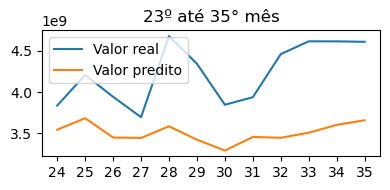

In [11]:
#Random Forest com parâmetros padrões e 100 estimadores	
plot_many = False
plot_one = True
df_xgbr = xgb.XGBRegressor(n_estimators=100)
df_xgbr.fit(X_train, y_train) # (154, 12), (154,)


default_rmse = []
default_mae = []
default_mape = []

if plot_many:
    fig, axs = plt.subplots(13, figsize=(4, 20))
if plot_one:
    chosen = np.random.randint(0, 25)
    fig, axs = plt.subplots(1, figsize=(4, 2))

for i in range(25):

    initial = icms_initial_values[i]
    y_pred = []

    X_case = X_val[i:i+1].copy()
    

    # Multi-step prediction
    for j in range(12):
        yhat = df_xgbr.predict(X_case)
        y_pred.append(yhat)
        X_case = np.concatenate([X_case[:, 1:], yhat.reshape(1, -1)], axis=1)
    
    # Desnormalizing
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_pred = y_pred * (_max - _min) + _min
    y_val_case = y_val[i:i+12].reshape(-1, 1) * (_max - _min) + _min

    # Retrending
    for j in range(12):
        if j == 0:
            y_pred[j] = y_pred[j] + initial
            y_val_case[j] = y_val_case[j] + initial
        else:
            y_pred[j] = y_pred[j] + y_pred[j-1]
            y_val_case[j] = y_val_case[j] + y_val_case[j-1]

    #Plotando
    if plot_many:
        if i % 2 == 0:
            axs[i//2].plot(y_val_case, label='Valor real')
            axs[i//2].plot(y_pred, label='Valor predito')
            axs[i//2].legend()
            axs[i//2].set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs[i//2].set_title(f"{i}º até {i+12}° mês")
    elif plot_one:
        if i == chosen:
            axs.plot(y_val_case, label='Valor real')
            axs.plot(y_pred, label='Valor predito')
            axs.legend()
            axs.set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs.set_title(f"{i}º até {i+12}° mês")

    # Calculating the error
    default_rmse.append(np.sqrt(mean_squared_error(y_val_case, y_pred)))
    default_mae.append(np.mean(np.abs(y_val_case - y_pred)))
    default_mape.append(np.mean(np.abs((y_val_case[:12] - y_pred[:12]) / y_val_case[:12])) * 100)
    
#Plotando metade dos gráficos de validação criados
plt.tight_layout()
plt.show()



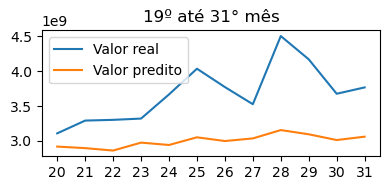

In [12]:
#Random Forest com parâmetros padrões e 100 estimadores	
plot_many = False
plot_one = True
df_xgbrfr = xgb.XGBRFRegressor(n_estimators=100)
df_xgbrfr.fit(X_train, y_train) # (154, 12), (154,)


default_xgbrfr_rmse = []
default_xgbrfr_mae = []
default_xgbrfr_mape = []

if plot_many:
    fig, axs = plt.subplots(13, figsize=(4, 20))
if plot_one:
    chosen = np.random.randint(0, 25)
    fig, axs = plt.subplots(1, figsize=(4, 2))

for i in range(25):

    initial = icms_initial_values[i]
    y_pred = []

    X_case = X_val[i:i+1].copy()
    

    # Multi-step prediction
    for j in range(12):
        yhat = df_xgbrfr.predict(X_case)
        y_pred.append(yhat)
        X_case = np.concatenate([X_case[:, 1:], yhat.reshape(1, -1)], axis=1)
    
    # Desnormalizing
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_pred = y_pred * (_max - _min) + _min
    y_val_case = y_val[i:i+12].reshape(-1, 1) * (_max - _min) + _min

    # Retrending
    for j in range(12):
        if j == 0:
            y_pred[j] = y_pred[j] + initial
            y_val_case[j] = y_val_case[j] + initial
        else:
            y_pred[j] = y_pred[j] + y_pred[j-1]
            y_val_case[j] = y_val_case[j] + y_val_case[j-1]

    #Plotando
    if plot_many:
        if i % 2 == 0:
            axs[i//2].plot(y_val_case, label='Valor real')
            axs[i//2].plot(y_pred, label='Valor predito')
            axs[i//2].legend()
            axs[i//2].set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs[i//2].set_title(f"{i}º até {i+12}° mês")
    elif plot_one:
        if i == chosen:
            axs.plot(y_val_case, label='Valor real')
            axs.plot(y_pred, label='Valor predito')
            axs.legend()
            axs.set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs.set_title(f"{i}º até {i+12}° mês")

    # Calculating the error
    default_xgbrfr_rmse.append(np.sqrt(mean_squared_error(y_val_case, y_pred)))
    default_xgbrfr_mae.append(np.mean(np.abs(y_val_case - y_pred)))
    default_xgbrfr_mape.append(np.mean(np.abs((y_val_case[:12] - y_pred[:12]) / y_val_case[:12])) * 100)
    
#Plotando metade dos gráficos de validação criados
plt.tight_layout()
plt.show()



#### Treinamento com parâmetros otimizados pelo grid

Também são calculadas as métricas de erro no conjunto de validação

[20:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.



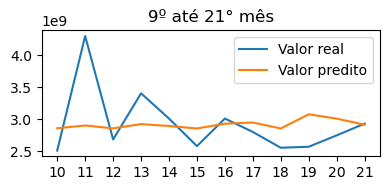

In [13]:
#Random Forest
plot_many = False
plot_one = True
best_xgbr = xgb.XGBRegressor(n_estimators= xgbr_ne, max_depth= xgbr_md, 
                             learning_rate= xgbr_lr, subsample= xgbr_ss, 
                             colsample_bytree= xgbr_cb, booster= xgbr_b)
best_xgbr.fit(X_train, y_train) # (154, 12), (154,)

best_rmse = []
best_mae = []
best_mape = []

if plot_many:
    fig, axs = plt.subplots(13, figsize=(4, 20))
elif plot_one:
    chosen = np.random.randint(0, 25)
    fig, axs = plt.subplots(1, figsize=(4, 2))
    
for i in range(25):
    initial = icms_initial_values[i]
    y_pred = []

    X_case = X_val[i:i+1].copy()

    # Multi-step prediction
    for j in range(12):
        yhat = best_xgbr.predict(X_case)
        y_pred.append(yhat)
        X_case = np.concatenate([X_case[:, 1:], yhat.reshape(1, -1)], axis=1)
    
    # Desnormalizing
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_pred = y_pred * (_max - _min) + _min
    y_val_case = y_val[i:i+12].reshape(-1, 1) * (_max - _min) + _min

    # Retrending
    for j in range(12):
        if j == 0:
            y_pred[j] = y_pred[j] + initial
            y_val_case[j] = y_val_case[j] + initial
        else:
            y_pred[j] = y_pred[j] + y_pred[j-1]
            y_val_case[j] = y_val_case[j] + y_val_case[j-1]

        #Plotando
    if plot_many:
        if i % 2 == 0:
            axs[i//2].plot(y_val_case, label='Valor real')
            axs[i//2].plot(y_pred, label='Valor predito')
            axs[i//2].legend()
            axs[i//2].set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs[i//2].set_title(f"{i}º até {i+12}° mês")
    elif plot_one:
        if i == chosen:
            axs.plot(y_val_case, label='Valor real')
            axs.plot(y_pred, label='Valor predito')
            axs.legend()
            axs.set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs.set_title(f"{i}º até {i+12}° mês")

    # Calculating the error
    best_rmse.append(np.sqrt(mean_squared_error(y_val_case, y_pred)))
    best_mae.append(np.mean(np.abs(y_val_case - y_pred)))
    best_mape.append(np.mean(np.abs((y_val_case[:12] - y_pred[:12]) / y_val_case[:12])) * 100)
    

#Plotando
plt.tight_layout()
plt.show()


[20:12:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bynode", "colsample_bytree", "max_depth", "num_parallel_tree", "subsample" } are not used.



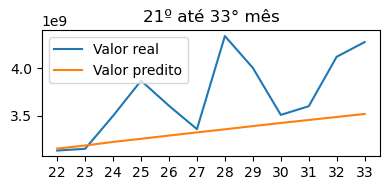

In [14]:
#Random Forest
plot_many = False
plot_one = True
best_xgbrfr = xgb.XGBRFRegressor(n_estimators= xgbrfr_ne, max_depth= xgbrfr_md, 
                             learning_rate= xgbrfr_lr, subsample= xgbrfr_ss, 
                             colsample_bytree= xgbrfr_cb, booster= xgbrfr_b)
best_xgbrfr.fit(X_train, y_train) # (154, 12), (154,)

best_xgbrfr_rmse = []
best_xgbrfr_mae = []
best_xgbrfr_mape = []

if plot_many:
    fig, axs = plt.subplots(13, figsize=(4, 20))
elif plot_one:
    chosen = np.random.randint(0, 25)
    fig, axs = plt.subplots(1, figsize=(4, 2))
    
for i in range(25):
    initial = icms_initial_values[i]
    y_pred = []

    X_case = X_val[i:i+1].copy()

    # Multi-step prediction
    for j in range(12):
        yhat = best_xgbrfr.predict(X_case)
        y_pred.append(yhat)
        X_case = np.concatenate([X_case[:, 1:], yhat.reshape(1, -1)], axis=1)
    
    # Desnormalizing
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_pred = y_pred * (_max - _min) + _min
    y_val_case = y_val[i:i+12].reshape(-1, 1) * (_max - _min) + _min

    # Retrending
    for j in range(12):
        if j == 0:
            y_pred[j] = y_pred[j] + initial
            y_val_case[j] = y_val_case[j] + initial
        else:
            y_pred[j] = y_pred[j] + y_pred[j-1]
            y_val_case[j] = y_val_case[j] + y_val_case[j-1]

        #Plotando
    if plot_many:
        if i % 2 == 0:
            axs[i//2].plot(y_val_case, label='Valor real')
            axs[i//2].plot(y_pred, label='Valor predito')
            axs[i//2].legend()
            axs[i//2].set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs[i//2].set_title(f"{i}º até {i+12}° mês")
    elif plot_one:
        if i == chosen:
            axs.plot(y_val_case, label='Valor real')
            axs.plot(y_pred, label='Valor predito')
            axs.legend()
            axs.set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs.set_title(f"{i}º até {i+12}° mês")

    # Calculating the error
    best_xgbrfr_rmse.append(np.sqrt(mean_squared_error(y_val_case, y_pred)))
    best_xgbrfr_mae.append(np.mean(np.abs(y_val_case - y_pred)))
    best_xgbrfr_mape.append(np.mean(np.abs((y_val_case[:12] - y_pred[:12]) / y_val_case[:12])) * 100)
    

#Plotando
plt.tight_layout()
plt.show()


#### Mostrando os parâmetros utilizado no caso Padrão e no Otimizado

In [15]:
print_mean_error("Validação: XGBRegressor Parâmetros Default Univariado",
                 default_rmse, default_mae, default_mape)
print_mean_error("Validação: XGBRegressor Parâmetros Otimizados Univariado",
                 best_rmse, best_mae, best_mape)
print_mean_error("Validação: XGBRFRegressor Parâmetros Default Univariado",
                 default_xgbrfr_rmse, default_xgbrfr_mae, default_xgbrfr_mape)
print_mean_error("Validação: XGBRFRegressor Parâmetros Otimizados Multivariado",
                 best_xgbrfr_rmse, best_xgbrfr_mae, best_xgbrfr_mape)
                 

Validação: XGBRegressor Parâmetros Default Univariado
	RMSE: 555862343.64
	MAE: 461797384.47
	MAPE: 16.07
----------------------------------------
Validação: XGBRegressor Parâmetros Otimizados Univariado
	RMSE: 589193019.23
	MAE: 484932566.63
	MAPE: 15.86
----------------------------------------
Validação: XGBRFRegressor Parâmetros Default Univariado
	RMSE: 552661839.88
	MAE: 457910489.74
	MAPE: 15.70
----------------------------------------
Validação: XGBRFRegressor Parâmetros Otimizados Multivariado
	RMSE: 557934794.49
	MAE: 458212553.04
	MAPE: 16.52
----------------------------------------


Dado a semelhança de resultados entre o XGBRegressor e o XGBRFRegressor, vamos escolher utilizar o XGBRegressor.

# Multivariado

## Casos multivariados com ICMS e uma série exógena

#### Preparando as tabelas com os lags

In [16]:
#['ANO', 'MES', 'ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA']
icms_cb_raw = df[['ICMS', 'CB']].copy()
icms_petr_raw = df[['ICMS', 'PETROLEO']].copy() 
icms_trib_raw = df[['ICMS', 'TRIBUTOS']].copy()
icms_ener_raw = df[['ICMS', 'ENERGIA']].copy()

In [17]:
icms_cb = series_to_supervised(icms_cb_raw, ['ICMS', 'CB'], 12, 1)
icms_petr = series_to_supervised(icms_petr_raw, ['ICMS', 'PETROLEO'], 12, 1)  
icms_trib = series_to_supervised(icms_trib_raw, ['ICMS', 'TRIBUTOS'], 12, 1)
icms_ener = series_to_supervised(icms_ener_raw, ['ICMS', 'ENERGIA'], 12, 1)
print(icms_cb.shape)
print(icms_petr.shape)
print(icms_trib.shape)
print(icms_ener.shape)  

(190, 26)
(190, 26)
(190, 26)
(190, 26)


#### GridSearch CV

In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xbgr = xgb.XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
icms_cb_random = RandomizedSearchCV(estimator = xbgr, param_distributions = random_grid, 
                                    n_iter = 100, cv = 3, scoring='neg_mean_squared_error',
                                    verbose=2, n_jobs = -1)
icms_petr_random = RandomizedSearchCV(estimator = xbgr, param_distributions = random_grid, 
                                    n_iter = 100, cv = 3, scoring='neg_mean_squared_error',
                                    verbose=2, n_jobs = -1)
icms_trib_random = RandomizedSearchCV(estimator = xbgr, param_distributions = random_grid, 
                                    n_iter = 100, cv = 3, scoring='neg_mean_squared_error',
                                    verbose=2, n_jobs = -1)
icms_ener_random = RandomizedSearchCV(estimator = xbgr, param_distributions = random_grid, 
                                    n_iter = 100, cv = 3, scoring='neg_mean_squared_error',
                                    verbose=2, n_jobs = -1)


# Fit the random search model
icms_cb_random.fit(icms_cb.values[:, :-1], icms_cb.values[:, -1])
icms_petr_random.fit(icms_petr.values[:, :-1], icms_petr.values[:, -1])
icms_trib_random.fit(icms_trib.values[:, :-1], icms_trib.values[:, -1])
icms_ener_random.fit(icms_ener.values[:, :-1], icms_ener.values[:, -1])

cb_ne, cb_md, cb_lr, cb_ss, cb_cb, cb_b = get_best_parameters(icms_cb_random.best_params_)
petr_ne, petr_md, petr_lr, petr_ss, petr_cb, petr_b = get_best_parameters(icms_petr_random.best_params_)
trib_ne, trib_md, trib_lr, trib_ss, trib_cb, trib_b = get_best_parameters(icms_trib_random.best_params_)
ener_ne, ener_md, ener_lr, ener_ss, ener_cb, ener_b = get_best_parameters(icms_ener_random.best_params_)

pprint(icms_cb_random.best_params_)
pprint(icms_petr_random.best_params_)
pprint(icms_trib_random.best_params_)
pprint(icms_ener_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[20:19:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[20:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[20:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[20:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost

#### Divisão de treinamento e validação

In [19]:
#Cesta Básicas + ICMS
#Dividindo em treino e validação
cb_train = icms_cb.values[:154, :]
cb_val = icms_cb.values[154:, :]    

#Dividindo em X e y
cb_X_train, cb_y_train = cb_train[:, :-2], cb_train[:, -2:]
cb_X_val, cb_y_val = cb_val[:, :-2], cb_val[:, -2:]

#Petróleo + ICMS
#Dividindo em treino e validação
petr_train = icms_petr.values[:154, :]
petr_val = icms_petr.values[154:, :]

#Dividindo em X e y
petr_X_train, petr_y_train = petr_train[:, :-2], petr_train[:, -2:]
petr_X_val, petr_y_val = petr_val[:, :-2], petr_val[:, -2:]

#Total de Tributos + ICMS
#Dividindo em treino e validação
trib_train = icms_trib.values[:154, :]
trib_val = icms_trib.values[154:, :]

#Dividindo em X e y
trib_X_train, trib_y_train = trib_train[:, :-2], trib_train[:, -2:]
trib_X_val, trib_y_val = trib_val[:, :-2], trib_val[:, -2:]

#Energia + ICMS
#Dividindo em treino e validação
ener_train = icms_ener.values[:154, :]
ener_val = icms_ener.values[154:, :]

#Dividindo em X e y
ener_X_train, ener_y_train = ener_train[:, :-2], ener_train[:, -2:]
ener_X_val, ener_y_val = ener_val[:, :-2], ener_val[:, -2:]

#### Treinamento dos 4 modelos

Caso ICMS + Cesta Básica

Caso ICMS + Produção Total de Petróleo 

Caso ICMS + Total Receita Tributária RJ

Caso ICMS + Consumo de Energia Total Sudeste

In [20]:
cb_xgb = xgb.XGBRegressor(n_estimators=100)
cb_xgb.fit(cb_X_train, cb_y_train) # (154, 24), (154,)

petr_xgb = xgb.XGBRegressor(n_estimators=100)
petr_xgb.fit(petr_X_train, petr_y_train) # (154, 24), (154,)

trib_xgb = xgb.XGBRegressor(n_estimators=100)
trib_xgb.fit(trib_X_train, trib_y_train) # (154, 24), (154,)

ener_xgb = xgb.XGBRegressor(n_estimators=100)
ener_xgb.fit(ener_X_train, ener_y_train) # (154, 24), (154,)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Treinamento dos 4 modelos com parâmetros otimizados

In [21]:
#Random Forest
opt_cb_xgb = xgb.XGBRegressor(n_estimators=cb_ne, max_depth=cb_md, learning_rate=cb_lr,
                             subsample=cb_ss, colsample_bytree=cb_cb, booster=cb_b  )
opt_cb_xgb.fit(cb_X_train, cb_y_train) # (154, 24), (154,)

opt_petr_xgb = xgb.XGBRegressor(n_estimators=petr_ne, max_depth=petr_md, learning_rate=petr_lr,
                               subsample=petr_ss, colsample_bytree=petr_cb, booster=petr_b)
opt_petr_xgb.fit(petr_X_train, petr_y_train) # (154, 24), (154,)

opt_trib_xgb = xgb.XGBRegressor(n_estimators=trib_ne, max_depth=trib_md, learning_rate=trib_lr,
                               subsample=trib_ss, colsample_bytree=trib_cb, booster=trib_b)
opt_trib_xgb.fit(trib_X_train, trib_y_train) # (154, 24), (154,)

opt_ener_xgb = xgb.XGBRegressor(n_estimators=ener_ne, max_depth=ener_md, learning_rate=ener_lr,
                               subsample=ener_ss, colsample_bytree=ener_cb, booster=ener_b)
opt_ener_xgb.fit(ener_X_train, ener_y_train) # (154, 24), (154,)

[20:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

[20:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

[20:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

[20:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.



XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.012, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=140, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Cálculo das métricas de erro no conjunto de validação

In [22]:
#fig, axs = plt.subplots(13, figsize=(4, 20))
#To use all Validation Set with 12 steps ahead horizon
# Criando 25 previsões com horizonte de 12 meses
# Para os 36 dados do conjunto de validação
for i in range(25):

    initial = icms_initial_values[i]
    cb_initial = cb_initial_values[i]
    petr_initial = petr_initial_values[i]
    trib_initial = trib_initial_values[i]
    ener_initial = ener_initial_values[i]

    cb_pred = []
    petr_pred = []
    trib_pred = []
    ener_pred = []
    opt_cb_pred = []
    opt_petr_pred = []
    opt_trib_pred = []
    opt_ener_pred = []

    cb_case = cb_X_val[i:i+1].copy() # (1,24)
    petr_case = petr_X_val[i:i+1].copy() # (1,24)
    trib_case = trib_X_val[i:i+1].copy() # (1,24)
    ener_case = ener_X_val[i:i+1].copy() # (1,24) 
    opt_cb_case = cb_X_val[i:i+1].copy() # (1,24)
    opt_petr_case = petr_X_val[i:i+1].copy() # (1,24)
    opt_trib_case = trib_X_val[i:i+1].copy() # (1,24)
    opt_ener_case = ener_X_val[i:i+1].copy() # (1,24)

    # Multi-step prediction for each case
    for j in range(12):
        cb_yhat = cb_xgb.predict(cb_case)   
        cb_pred.append(cb_yhat)
        cb_case = np.concatenate([cb_case[:, 2:], cb_yhat.reshape(1, -1)], axis=1)

        petr_yhat = petr_xgb.predict(petr_case)
        petr_pred.append(petr_yhat)
        petr_case = np.concatenate([petr_case[:, 2:], petr_yhat.reshape(1, -1)], axis=1)

        trib_yhat = trib_xgb.predict(trib_case)
        trib_pred.append(trib_yhat)
        trib_case = np.concatenate([trib_case[:, 2:], trib_yhat.reshape(1, -1)], axis=1)

        ener_yhat = ener_xgb.predict(ener_case)
        ener_pred.append(ener_yhat)
        ener_case = np.concatenate([ener_case[:, 2:], ener_yhat.reshape(1, -1)], axis=1)

        opt_cb_yhat = opt_cb_xgb.predict(opt_cb_case)
        opt_cb_pred.append(opt_cb_yhat)
        opt_cb_case = np.concatenate([opt_cb_case[:, 2:], opt_cb_yhat.reshape(1, -1)], axis=1)

        opt_petr_yhat = opt_petr_xgb.predict(opt_petr_case)
        opt_petr_pred.append(opt_petr_yhat)
        opt_petr_case = np.concatenate([opt_petr_case[:, 2:], opt_petr_yhat.reshape(1, -1)], axis=1)

        opt_trib_yhat = opt_trib_xgb.predict(opt_trib_case)
        opt_trib_pred.append(opt_trib_yhat)
        opt_trib_case = np.concatenate([opt_trib_case[:, 2:], opt_trib_yhat.reshape(1, -1)], axis=1)

        opt_ener_yhat = opt_ener_xgb.predict(opt_ener_case)
        opt_ener_pred.append(opt_ener_yhat)
        opt_ener_case = np.concatenate([opt_ener_case[:, 2:], opt_ener_yhat.reshape(1, -1)], axis=1)

    

    # Desnormalizing and Retrending
    cb_pred, cb_val_case = denorm_and_retrend(cb_pred, cb_y_val[i:i+12], 
                                              _max, _min, cb_max, cb_min, 
                                              initial, cb_initial)
    petr_pred, petr_val_case = denorm_and_retrend(petr_pred, petr_y_val[i:i+12],
                                                  _max, _min, petr_max, petr_min,
                                                  initial, petr_initial)
    trib_pred, trib_val_case = denorm_and_retrend(trib_pred, trib_y_val[i:i+12],
                                                  _max, _min, trib_max, trib_min,
                                                  initial, trib_initial)
    ener_pred, ener_val_case = denorm_and_retrend(ener_pred, ener_y_val[i:i+12],
                                                  _max, _min, ener_max, ener_min,
                                                  initial, ener_initial)
    opt_cb_pred, opt_cb_val_case = denorm_and_retrend(opt_cb_pred, cb_y_val[i:i+12],
                                                        _max, _min, cb_max, cb_min,
                                                        initial, cb_initial)
    opt_petr_pred, opt_petr_val_case = denorm_and_retrend(opt_petr_pred, petr_y_val[i:i+12],
                                                            _max, _min, petr_max, petr_min,
                                                            initial, petr_initial)
    opt_trib_pred, opt_trib_val_case = denorm_and_retrend(opt_trib_pred, trib_y_val[i:i+12],
                                                            _max, _min, trib_max, trib_min,
                                                            initial, trib_initial)
    opt_ener_pred, opt_ener_val_case = denorm_and_retrend(opt_ener_pred, ener_y_val[i:i+12],
                                                            _max, _min, ener_max, ener_min,
                                                            initial, ener_initial)
          
    cb_rmse, cb_mae, cb_mape = calculate_error(cb_pred, cb_val_case)      
    petr_rmse, petr_mae, petr_mape = calculate_error(petr_pred, petr_val_case)
    trib_rmse, trib_mae, trib_mape = calculate_error(trib_pred, trib_val_case)
    ener_rmse, ener_mae, ener_mape = calculate_error(ener_pred, ener_val_case)
    opt_cb_rmse, opt_cb_mae, opt_cb_mape = calculate_error(opt_cb_pred, opt_cb_val_case)
    opt_petr_rmse, opt_petr_mae, opt_petr_mape = calculate_error(opt_petr_pred, opt_petr_val_case)
    opt_trib_rmse, opt_trib_mae, opt_trib_mape = calculate_error(opt_trib_pred, opt_trib_val_case)
    opt_ener_rmse, opt_ener_mae, opt_ener_mape = calculate_error(opt_ener_pred, opt_ener_val_case)
    
#Plotando
# plt.tight_layout()
# plt.show()

## Multivariado com todas as séries

#### Criação da tabela contendo todas as séries

In [7]:
all_series_raw = df[['ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA']]
all_df = series_to_supervised(all_series_raw, ['ICMS', 'CB', 'PETROLEO', 'TRIBUTOS', 'ENERGIA'], 12, 1)
print(all_df.shape)
all_df.head()

(190, 65)


,ICMS(t-12),CB(t-12),PETROLEO(t-12),TRIBUTOS(t-12),ENERGIA(t-12),ICMS(t-11),CB(t-11),PETROLEO(t-11),TRIBUTOS(t-11),ENERGIA(t-11),...,ICMS(t-1),CB(t-1),PETROLEO(t-1),TRIBUTOS(t-1),ENERGIA(t-1),ICMS(t),CB(t),PETROLEO(t),TRIBUTOS(t),ENERGIA(t)
12,0.453713,0.680444,0.587234,0.426264,0.496627,0.494609,0.664873,0.457447,0.446347,0.616310,...,0.413514,0.699110,0.521277,0.383802,0.335289,0.468697,0.635779,0.623404,0.437047,0.546788
13,0.494609,0.664873,0.457447,0.446347,0.616310,0.473085,0.730537,0.465957,0.437884,0.266940,...,0.468697,0.635779,0.623404,0.437047,0.546788,0.494049,0.701062,0.797872,0.448239,0.672045
14,0.473085,0.730537,0.465957,0.437884,0.266940,0.502279,0.686920,0.657447,0.480698,0.438838,...,0.494049,0.701062,0.797872,0.448239,0.672045,0.460907,0.703252,0.568085,0.430126,0.229393
15,0.502279,0.686920,0.657447,0.480698,0.438838,0.486677,0.612923,0.578723,0.454444,0.498387,...,0.460907,0.703252,0.568085,0.430126,0.229393,0.441648,0.590924,0.572340,0.412021,0.456439
16,0.486677,0.612923,0.578723,0.454444,0.498387,0.480029,0.733013,0.497872,0.452790,0.469346,...,0.441648,0.590924,0.572340,0.412021,0.456439,0.496061,0.691253,0.497872,0.468748,0.404517


#### Divisão em treino e validação

In [8]:
#Dividindo em treino e validação
all_train = all_df.values[:154, :]
all_val = all_df.values[154:, :]    

#Dividindo em X e y
all_X_train, all_y_train = all_train[:, :-5], all_train[:, -5:]
all_X_val, all_y_val = all_val[:, :-5], all_val[:, -5:]

#### Treinamento e cálculo das métricas de erro no conjunto de validação

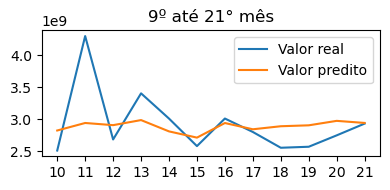

In [9]:
plot_many = False
plot_one = True
all_xgb = xgb.XGBRegressor(n_estimators=100)
all_xgb.fit(all_X_train, all_y_train) # (154, 12), (154,)


all_rmse = []
all_mae = []
all_mape = []

if plot_many:
    fig, axs = plt.subplots(13, figsize=(4, 20))
elif plot_one:
    chosen = np.random.randint(0, 25)
    fig, axs = plt.subplots(1, figsize=(4, 2))

for i in range(25):

    initial = icms_initial_values[i]
    cb_initial = cb_initial_values[i]
    petr_initial = petr_initial_values[i]
    trib_initial = trib_initial_values[i]
    ener_initial = ener_initial_values[i]
    y_pred = []

    X_case = all_X_val[i:i+1].copy()

    # Multi-step prediction
    for j in range(12):
        yhat = all_xgb.predict(X_case)
        y_pred.append(yhat)
        X_case = np.concatenate([X_case[:, 5:], yhat.reshape(1, -1)], axis=1)
    

    y_pred, y_val_case = denorm_and_retrend_all(y_pred, all_y_val[i:i+12], initial,
                                                cb_initial, petr_initial, 
                                                trib_initial, ener_initial)

    icms_pred = y_pred[::5]
    icms_val_case = y_val_case[::5]

    #Plotando
    if plot_many:
        if i % 2 == 0:
            axs[i//2].plot(icms_val_case, label='Valor real')
            axs[i//2].plot(icms_pred, label='Valor predito')
            axs[i//2].legend()
            axs[i//2].set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs[i//2].set_title(f"{i}º até {i+12}° mês")
    elif plot_one:
        if i == chosen:
            axs.plot(icms_val_case, label='Valor real')
            axs.plot(icms_pred, label='Valor predito')
            axs.legend()
            axs.set(xticks=np.arange(0, 12, 1), xticklabels=np.arange(i+1, i+13, 1))
            axs.set_title(f"{i}º até {i+12}° mês")

    # Calculating the error
    all_rmse.append(np.sqrt(mean_squared_error(y_val_case, y_pred)))
    all_mae.append(np.mean(np.abs(y_val_case - y_pred)))
    all_mape.append(np.mean(np.abs((y_val_case - y_pred) / y_val_case)) * 100)
    
#Plotando
plt.tight_layout()
plt.show()


### Comparação de todos os resultados no conjunto de validação

In [26]:
#Comparando os resultados
print_mean_error("Validação: Parâmetros Default Univariado",
                 default_rmse, default_mae, default_mape)
print_mean_error("Validação: Parâmetros Otimizados Univariado",
                best_rmse, best_mae, best_mape)
print_mean_error("Validação: CB + ICMS Multivariado",
                cb_rmse, cb_mae, cb_mape)
print_mean_error("Validação: CB + ICMS Otimizado Multivariado",
                 opt_cb_rmse, opt_cb_mae, opt_cb_mape)
print_mean_error("Validação: Petróleo + ICMS Multivariado",
                petr_rmse, petr_mae, petr_mape)
print_mean_error("Validação: Petróleo + ICMS Otimizado Multivariado",
                opt_petr_rmse, opt_petr_mae, opt_petr_mape) 
print_mean_error("Validação: Tributos + ICMS Multivariado",
                trib_rmse, trib_mae, trib_mape)
print_mean_error("Validação: Tributos + ICMS Otimizado Multivariado",
                opt_trib_rmse, opt_trib_mae, opt_trib_mape)
print_mean_error("Validação: Energia + ICMS Multivariado",
                ener_rmse, ener_mae, ener_mape)
print_mean_error("Validação: Energia + ICMS Otimizado Multivariado",
                opt_ener_rmse, opt_ener_mae, opt_ener_mape)
print_mean_error("Validação: Todos os parâmetros Multivariado",
                all_rmse, all_mae, all_mape)      

Validação: Parâmetros Default Univariado
	RMSE: 555862343.64
	MAE: 461797384.47
	MAPE: 16.07
----------------------------------------
Validação: Parâmetros Otimizados Univariado
	RMSE: 589193019.23
	MAE: 484932566.63
	MAPE: 15.86
----------------------------------------
Validação: CB + ICMS Multivariado
	RMSE: 204121982.68
	MAE: 126568089.58
	MAPE: 4.62
----------------------------------------
Validação: CB + ICMS Otimizado Multivariado
	RMSE: 349684977.09
	MAE: 208546187.22
	MAPE: 9.47
----------------------------------------
Validação: Petróleo + ICMS Multivariado
	RMSE: 329786966.72
	MAE: 198750649.45
	MAPE: 9.32
----------------------------------------
Validação: Petróleo + ICMS Otimizado Multivariado
	RMSE: 353986889.76
	MAE: 211285037.14
	MAPE: 9.76
----------------------------------------
Validação: Tributos + ICMS Multivariado
	RMSE: 671264018.79
	MAE: 560706440.47
	MAPE: 9.90
----------------------------------------
Validação: Tributos + ICMS Otimizado Multivariado
	RMSE: 8007

# Resultados de Teste

## Teste Univariado

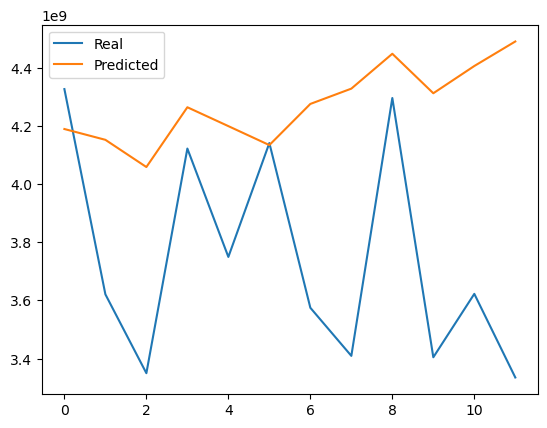

In [27]:
# Using test set Univariate

#Getting 12 months before the test set
test = icms[-1:].values[0][1:]
pred = []

for i in range(12):
    y_hat = df_xgbr.predict(test.reshape(1, -1))
    test = np.concatenate([test[1:], y_hat], axis=0)    
    #Desnormalizing
    y_hat = y_hat * (_max - _min) + _min
    pred.append(y_hat[0])

#Retrending
for i in range(12):
    if i == 0:
        pred[i] = pred[i] + initial_icms_test_value
    else:
        pred[i] = pred[i] + pred[i-1]

pred = np.array(pred)

rmse, mae, mape = calculate_error(pred, icms_test_real)

plt.plot(icms_test_real, label='Real')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

## Teste Multivariado (ICMS + 1 série Exógena)

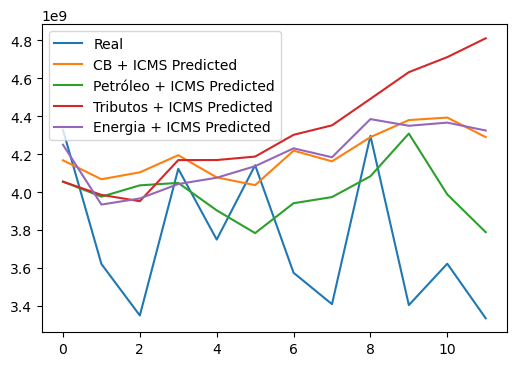

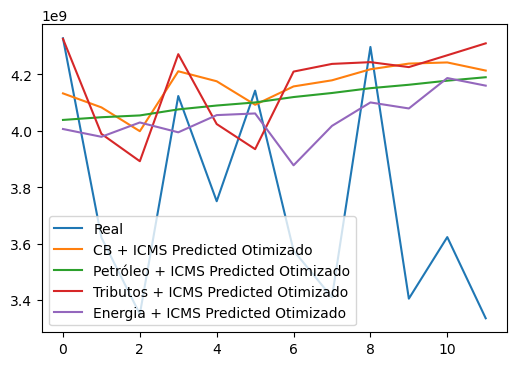

In [42]:
#Multivariado

cb_test = icms_cb[-1:].values[0][2:]
petr_test = icms_petr[-1:].values[0][2:]
trib_test = icms_trib[-1:].values[0][2:]
ener_test = icms_ener[-1:].values[0][2:]

cb_pred = get_prediction(cb_test, cb_xgb, initial_icms_test_value)
petr_pred = get_prediction(petr_test, petr_xgb, initial_icms_test_value)
trib_pred = get_prediction(trib_test, trib_xgb, initial_icms_test_value)
ener_pred = get_prediction(ener_test, ener_xgb, initial_icms_test_value)
opt_cb_pred = get_prediction(cb_test, opt_cb_xgb, initial_icms_test_value)
opt_petr_pred = get_prediction(petr_test, opt_petr_xgb, initial_icms_test_value)
opt_trib_pred = get_prediction(trib_test, opt_trib_xgb, initial_icms_test_value)
opt_ener_pred = get_prediction(ener_test, opt_ener_xgb, initial_icms_test_value)

plt.figure(figsize=(6,4))
plt.plot(icms_test_real, label='Real')
plt.plot(cb_pred, label='CB + ICMS Predicted')
plt.plot(petr_pred, label='Petróleo + ICMS Predicted')
plt.plot(trib_pred, label='Tributos + ICMS Predicted')
plt.plot(ener_pred, label='Energia + ICMS Predicted')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(icms_test_real, label='Real')
plt.plot(opt_cb_pred, label='CB + ICMS Predicted Otimizado')
plt.plot(opt_petr_pred, label='Petróleo + ICMS Predicted Otimizado')
plt.plot(opt_trib_pred, label='Tributos + ICMS Predicted Otimizado')
plt.plot(opt_ener_pred, label='Energia + ICMS Predicted Otimizado')
plt.legend()
plt.show()


In [20]:
all_df[-1:]

,ICMS(t-12),CB(t-12),PETROLEO(t-12),TRIBUTOS(t-12),ENERGIA(t-12),ICMS(t-11),CB(t-11),PETROLEO(t-11),TRIBUTOS(t-11),ENERGIA(t-11),...,ICMS(t-1),CB(t-1),PETROLEO(t-1),TRIBUTOS(t-1),ENERGIA(t-1),ICMS(t),CB(t),PETROLEO(t),TRIBUTOS(t),ENERGIA(t)
213,-2.367896e+08,8.91,-19.0,-177923341.8,487.0,3.060421e+08,25.91,195.0,1.430973e+09,-202.0,...,2.183444e+08,-9.17,-155.0,2.485736e+08,46.0,-2.879073e+08,-9.48,-12.0,-2.749783e+08,337.0


In [19]:
all_df[-1:].values[0][:-5]
#-2.879073e+08	-9.48	-12.0	-2.749783e+08	337.0

array([-2.36789635e+08,  8.91000000e+00, -1.90000000e+01, -1.77923342e+08,
        4.87000000e+02,  3.06042134e+08,  2.59100000e+01,  1.95000000e+02,
        1.43097276e+09, -2.02000000e+02, -7.06681487e+08, -2.20300000e+01,
       -1.23000000e+02, -1.42841554e+09, -8.50000000e+01, -2.71567083e+08,
        4.88000000e+01,  7.70000000e+01, -4.12788077e+08,  1.19500000e+03,
        7.73481530e+08, -3.56300000e+01,  1.00000000e+01,  6.79976202e+08,
        3.10000000e+01, -3.73152429e+08, -6.25800000e+01, -1.33000000e+02,
       -5.54831161e+08, -9.24000000e+02,  3.92199225e+08,  5.44600000e+01,
       -4.60000000e+01,  4.01391500e+08, -1.02500000e+03, -5.67242394e+08,
       -1.89800000e+01,  1.42000000e+02, -5.33544573e+08,  1.79000000e+02,
       -1.65663549e+08,  3.46000000e+00,  1.18000000e+02, -3.36737892e+08,
        4.30000000e+02,  8.87855189e+08,  2.25000000e+00,  7.10000000e+01,
        9.18724351e+08, -1.59000000e+02, -8.92692002e+08,  2.58200000e+01,
        8.80000000e+01, -

In [6]:
all_test = all_df[-1:].values[0][5:]
print(all_test.shape)

(60,)


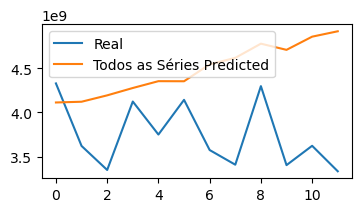

In [25]:
all_test = all_df[-1:].values[0][5:]

all_pred = []

for i in range(12):
    y_hat = all_xgb.predict(all_test.reshape(1, -1))
    all_test = np.concatenate([all_test[5:], y_hat.reshape(-1)], axis=0)
    #Desnormalizing
    y_hat = y_hat * (_max - _min) + _min
    all_pred.append(y_hat[0][0])

#Retrending
for i in range(12):
    if i == 0:
        all_pred[i] = all_pred[i] + initial_icms_test_value
    else:
        all_pred[i] = all_pred[i] + all_pred[i-1]

all_pred = np.array(all_pred)

plt.figure(figsize=(4,2))
plt.plot(icms_test_real, label='Real')
plt.plot(all_pred, label='Todos as Séries Predicted')
plt.legend()
plt.show()


In [36]:
print_results('Testes: ICMS Univariado', pred, icms_test_real)
print_results('Testes: CB + ICMS Multivariado ', cb_pred, icms_test_real)
print_results('Testes: CB + ICMS Multivariado Otimizado', opt_cb_pred, icms_test_real)
print_results('Testes: Petróleo + ICMS Multivariado ', petr_pred, icms_test_real)
print_results('Testes: Petróleo + ICMS Multivariado Otimizado', opt_petr_pred, icms_test_real)
print_results('Testes: Tributos + ICMS Multivariado ', trib_pred, icms_test_real)  
print_results('Testes: Tributos + ICMS Multivariado Otimizado', opt_trib_pred, icms_test_real)
print_results('Testes: Energia + ICMS Multivariado ', ener_pred, icms_test_real)
print_results('Testes: Energia + ICMS Multivariado Otimizado', opt_ener_pred, icms_test_real)
print_results('Testes: Todos os parâmetros Multivariado ', all_pred, icms_test_real)

Testes: CB + ICMS Multivariado 
	RMSE: 602832649.07
	MAE: 497760758.99
	MAPE: 14.21
----------------------------------------
Testes: CB + ICMS Multivariado Otimizado
	RMSE: 551615240.05
	MAE: 469299201.66
	MAPE: 13.33
----------------------------------------
Testes: Petróleo + ICMS Multivariado 
	RMSE: 455153812.71
	MAE: 397408218.56
	MAPE: 11.10
----------------------------------------
Testes: Petróleo + ICMS Multivariado Otimizado
	RMSE: 527457306.48
	MAE: 452758309.23
	MAPE: 12.82
----------------------------------------
Testes: Tributos + ICMS Multivariado 
	RMSE: 768404642.44
	MAE: 617673953.40
	MAPE: 17.56
----------------------------------------
Testes: Tributos + ICMS Multivariado Otimizado
	RMSE: 555372755.42
	MAE: 458255958.99
	MAPE: 13.06
----------------------------------------
Testes: Energia + ICMS Multivariado 
	RMSE: 582069746.65
	MAE: 468261599.85
	MAPE: 13.40
----------------------------------------
Testes: Energia + ICMS Multivariado Otimizado
	RMSE: 479865190.89
	MA